# 目的
出荷調整のための短期間での市場価格予測

大きな損失を避けることが目的

- 移動平均
- リグレット解析による評価

## 分析内容
週ごとの分析による現状の予測結果の問題点の確認

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import japanize_matplotlib
import lightgbm as lgb

In [2]:
def root_mean_squared_error(y_pred, y_test):
    return mean_squared_error(y_pred, y_test)**(1/2)

In [3]:
df_raw = pd.read_csv("../data/kk.csv")
# 全体のみを利用(産地名NaN)
is_nan = [df_raw["産地名"][i] is df_raw["産地名"][0] for i in range(df_raw.shape[0])]
df = df_raw[is_nan].copy()
del_columns = ["産地名", "産地コード", "品目名", "品目コード", "対前日比（数量）", "対前日比（価格）"]
df = df.drop(del_columns, axis=1).copy()


In [4]:
# 曜日の処理
dow = ["月", "火", "水", "木", "金", "土", "日"]
df["曜日"] = [dow.index(dw) for dw in df["曜日"]]


In [5]:
# 日にちの処理
# timestamp型 → timedelta
# date_columns = ["年", "月", "日"]
date = [str(df["年"].iloc[i])+"-"+str(df["月"].iloc[i])+"-" +
        str(df["日"].iloc[i]) for i in range(df.shape[0])]
df["date"] = pd.to_datetime(date)
# df = df.drop(date_columns, axis=1).copy()
df["days"] = [(date - df["date"][0]).days for date in df["date"]]
# df = df.drop("date", axis=1).copy()


In [6]:
# 特異日 (天皇即位)
outlier = df[df["価格"].max() == df["価格"]].index 
# df = df.drop(outlier, axis=0).copy()

In [7]:
# 数量で重み付け
def ma_weighted(price, df):
    """
    Args:
        price (df.rolling): df.rolling.apply()を想定した価格列
        df: 重み列を取るための元df
    return:
        ma_w = 数量加重移動平均
    """

    df_price = df.loc[price.index, '価格']
    df_num = df.loc[price.index, '数量']
    
    ma_w = 0
    for p, n in zip(df_price, df_num):
        ma_w += n * p/df_num.sum()

    return ma_w


In [8]:
ma_w3 = df["価格"].rolling(3).apply(ma_weighted, args=(df,), raw=False)
ma_w5 = df["価格"].rolling(5).apply(ma_weighted, args=(df,), raw=False)
ma_w7 = df["価格"].rolling(7).apply(ma_weighted, args=(df,), raw=False)


In [9]:
# train-test-split
# 7年分をtrain，3年分をtest(index 9426以上)
ma_w5 = ma_w5.dropna()
df_train = ma_w5[ma_w5.index < 9426].copy()
df_test = ma_w5[ma_w5.index >= 9426].copy()


In [10]:
date_train_raw = df.loc[df_train.index, ["年", "月", "日", "曜日"]].copy()
date_test_raw = df.loc[df_test.index, ["年", "月", "日", "曜日"]].copy()

In [11]:
# 学習データ作成
n_train = df_train.shape[0] - 7 - 6
X_train_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_train)]
y_train_idx = [i + 7 + 6 for i in range(n_train)]

date_train_idx = [i + 6 for i in range(n_train)]

n_test = df_test.shape[0] - 7 - 6
X_test_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_test)]
y_test_idx = [i + 7 + 6 for i in range(n_test)]

date_test_idx = [i + 6 for i in range(n_test)]

X_train = np.array([df_train.iloc[xt_i].values for xt_i in X_train_idx])

y_train = np.array([df_train.iloc[yt_i] for yt_i in y_train_idx])

X_test = np.array([df_test.iloc[xt_i].values for xt_i in X_test_idx])
y_test = np.array([df_test.iloc[yt_i] for yt_i in y_test_idx])

In [12]:
X_train = pd.DataFrame(X_train, columns=np.arange(7))
X_test = pd.DataFrame(X_test, columns=np.arange(7))
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [13]:
date_train = date_train_raw.iloc[date_train_idx].reset_index(drop=True)
date_test = date_test_raw.iloc[date_test_idx].reset_index(drop=True)

In [14]:
X_train = pd.concat([X_train, date_train], axis=1)
X_test = pd.concat([X_test, date_test], axis=1)

In [15]:
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape[0]
print(mape)

187.275739116027
0.06050149909514425


Text(0.5, 1.0, '市場価格5日移動平均の予測')

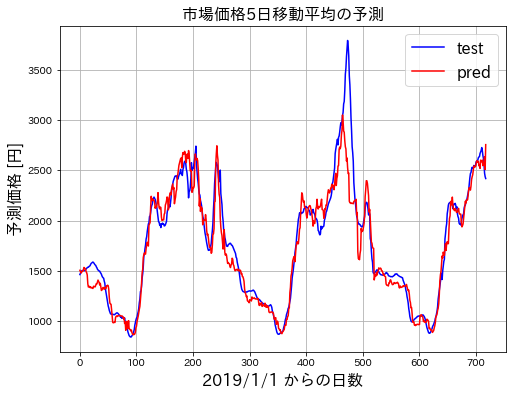

In [16]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend(fontsize=16)
ax.set_xlabel("2019/1/1 からの日数", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("市場価格5日移動平均の予測", fontsize=16)

In [17]:
test_year_index = df[df["年"] >= 2019].index

In [18]:
year2020_index_temp = df[df["年"] == 2020].index

In [19]:
year2020_index = np.arange(list(test_year_index).index(year2020_index_temp[0]),list(test_year_index).index(year2020_index_temp[-1]))

## 2020年9月から2021年8月に関して

In [36]:
df[(df["date"] >= pd.to_datetime("2020-08-01")) & (df["date"] < pd.to_datetime("2021-08-01"))]

,年,月,日,曜日,数量,価格,date,days
11802,2020,8,1,5,3633,2117,2020-08-01,3131
11807,2020,8,3,0,4664,2082,2020-08-03,3133
11811,2020,8,4,1,3842,2060,2020-08-04,3134
11816,2020,8,6,3,5090,2077,2020-08-06,3136
11821,2020,8,7,4,3551,1922,2020-08-07,3137
...,...,...,...,...,...,...,...,...
13253,2021,7,27,1,4808,2140,2021-07-27,3491
13258,2021,7,28,2,2285,1850,2021-07-28,3492
13262,2021,7,29,3,5678,2157,2021-07-29,3493
13267,2021,7,30,4,2099,2106,2021-07-30,3494


In [37]:
y_test

249    2269.507772
250    2211.285266
251    2160.812573
252    2050.388576
253    1998.577958
          ...     
508    2160.371901
509    2115.974233
510    2056.623049
511    2065.192631
512    2066.562031
Length: 264, dtype: float64

In [20]:
date = df[df["年"] == 2020]["date"]

y_test_temp = y_test.copy()
y_pred_temp = y_pred.copy()
y_test = y_test[249:249+264]
y_pred = y_pred[249:249+264]

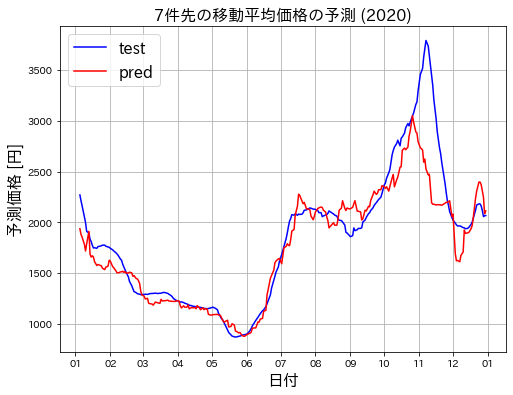

In [25]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(date, y_test, "b", label="test")
ax.plot(date, y_pred, "r", label="pred")
ax.legend(fontsize=16)
ax.set_xlabel("日付", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("7件先の移動平均価格の予測 (2020)", fontsize=16)

xfmt = mdates.DateFormatter("%m")
xloc = mdates.MonthLocator()

ax.xaxis.set_major_locator(xloc)
ax.xaxis.set_major_formatter(xfmt)

fig.show()

In [22]:
y_test = y_test_temp.copy()
y_pred = y_pred_temp.copy()

### 考察
- 概形は確かに一致
- 予測結果の振動がいまだに存在
- ピーク付近での振動は特に激しい

## 週ごとの分析
- 50日ごとにプロット
- [[0~7], [50~57], ...]

In [23]:
week_days = np.arange(50)
start_days = np.arange(5) * 50

In [24]:
y_test_temp = y_test.copy()
y_pred_temp = y_pred.copy()
y_test = y_test[year2020_index]
y_pred = y_pred[year2020_index]

In [25]:
plot_list = np.array([week_days + sd for sd in start_days])

In [26]:
plot_list[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [27]:
y_test

262    1760.452754
263    1765.817702
264    1768.361418
265    1775.199792
266    1775.189556
          ...     
520    1475.417302
521    1483.318784
522    1489.665467
523    1495.269286
524    1506.134888
Length: 263, dtype: float64

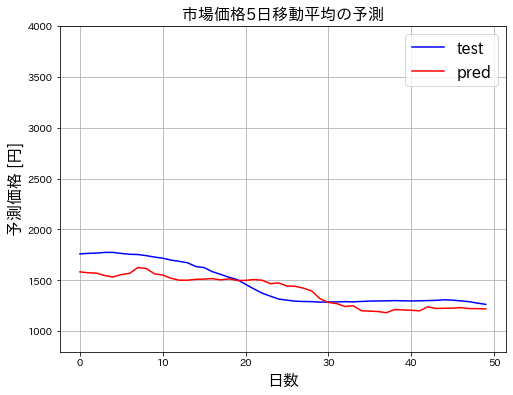

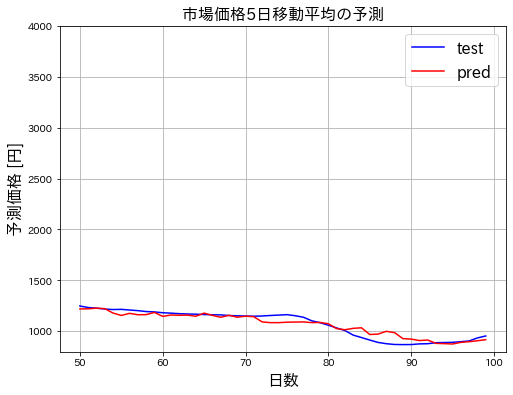

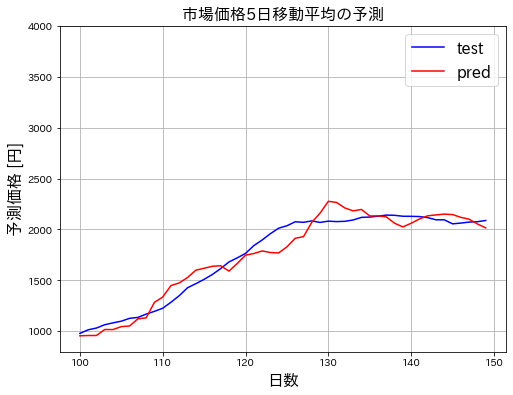

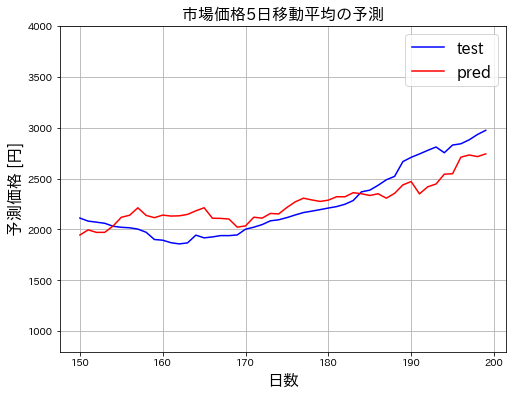

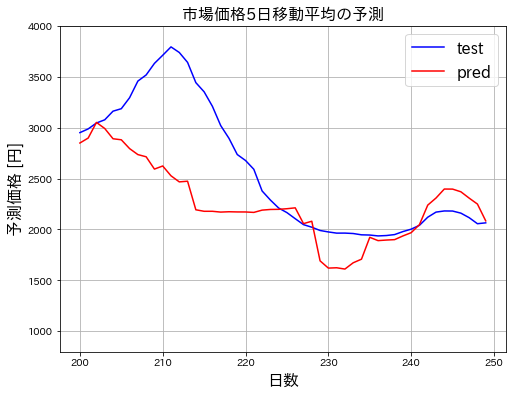

In [28]:
for pl in plot_list:
    fig, ax = plt.subplots()
    ax.grid()
    fig.set_figwidth(8)
    fig.set_figheight(6)

    ax.plot(pl, y_test.iloc[pl], "b", label="test")
    ax.plot(pl, y_pred[pl], "r", label="pred")
    ax.legend(fontsize=16)
    ax.set_xlabel("日数", fontsize=16)
    ax.set_ylabel("予測価格 [円]", fontsize=16)
    ax.set_title("市場価格5日移動平均の予測", fontsize=16)

    ax.set_ylim([800,4000])

In [29]:
y_diff = y_test - y_pred

In [30]:
y_diff.mean()

68.89826059061926

低めに予測している傾向があることがわかる

Text(0, 0.5, '市場価格 - 予測価格 [円]')

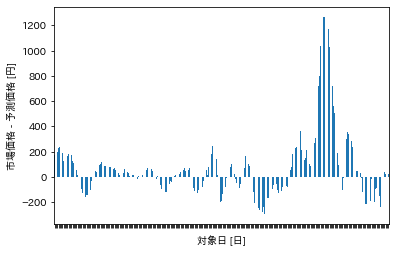

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
y_diff.plot(ax=ax, kind="bar")
ax.set_xticklabels([])
ax.set_xlabel("対象日 [日]")
ax.set_ylabel("市場価格 - 予測価格 [円]")

- 正：売っていれば得だが売らない可能性が高くなる → 損
- 誤：差額 = 損

# どんな時に損？
- 市場価格が高い日が周辺の予測価格より低い予測になっている場合（市場価格が高い日の市場価格 - 予測価格最大の日の市場価格）
- 予測価格が市場価格より高い場合（差額＝損失）

→ 概形があっていれば(最大最小が一致)低めに予測してもok
- 50日単位では大幅な損失は出ない
- 10日単位で最大値の予測を可能としているかは微妙

→ 高めに予測するのはまずい、年間最大値の直前でその傾向が見られる（許容範囲？）

→ 最大値の週でピークだけでも合わせられると更によくなりそうではある